## Data Science Candidate Evaluation: Exploratory Data Analysis for Forecasting Task
### 📄 Introduction
Welcome to the evaluation phase of your application for the Data Science position. This notebook is designed to assess your skills in exploratory data analysis (EDA) and forecasting. You will be provided with a dataset and a series of tasks aimed at testing your ability to interpret data and extract meaningful insights that could inform future forecasting models.

### 🎯 Objective
Your main objective in this notebook is to conduct a thorough exploratory analysis of the provided dataset. You should aim to understand the underlying patterns, trends, and anomalies within the data. The insights you generate here will be pivotal for building robust forecasting models in later stages.

### 📚 Dataset Description
* 	📆 Calendar.csv
    - DATE
    - STORE_ID
    - STATE
        - C : Closed
        - A : Open
        - FA : Open on holiday
        - FM : Open on holiday until noon
        - CR : Closed for renovation
    - OPENING_TIME
    - CLOSING_TIME 
    - HOLIDAY_AND_CLOSED
        - 1: True,  0: False
    - UNDER_REFORM
        - 1: True, 0: False
* 📉 ipc_history.csv
    - Evolution of IPC over time
* 📝 sales_test_submission.csv
    - File for results. Colums SALES must be filled with predictions
* 📈 sales_train_dataset.csv
    - Cumulative sales over time



##### Task 1: Import all necessary libraries

In [232]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from datetime import time

##### Task 2: Load all CSV files (format data if necessary)

Upon loading the data, we noticed that columns are separated by pipes (|) instead of the default comma delimiter. To correctly parse the data, we specified the delimiter='|' option during file reading.

In [233]:
calendar_df = pd.read_csv("../data/calendar.csv", delimiter='|', skipinitialspace=True)
ipc_history_df = pd.read_csv("../data/ipc_history.csv", delimiter='|', skipinitialspace=True)
sales_train_df = pd.read_csv("../data/sales_train_dataset.csv", delimiter='|', skipinitialspace=True)
sales_test_df = pd.read_csv("../data/sales_test_submission.csv", delimiter='|', skipinitialspace=True)

Ensure the date columns is in datetime format

In [234]:
sales_train_df['DATE'] = pd.to_datetime(sales_train_df['DATE'])
ipc_history_df['FEC_VENTA'] = pd.to_datetime(ipc_history_df['FEC_VENTA'])
sales_train_df['DATE'] = pd.to_datetime(sales_train_df['DATE'])
sales_test_df['DATE'] = pd.to_datetime(sales_test_df['DATE'])

The hours in calendar_df are represented as integers, so we converted the numeric (HHMM) format into a proper time object.

In [235]:
def convert_to_time_object(time_val):
    if pd.isna(time_val):  # Handle missing values
        return None
    hours = int(time_val) // 100
    minutes = int(time_val) % 100
    return time(hours, minutes)

calendar_df['OPENING_TIME'] = calendar_df['OPENING_TIME'].apply(convert_to_time_object)
calendar_df['CLOSING_TIME'] = calendar_df['CLOSING_TIME'].apply(convert_to_time_object)

In [236]:
# Calendar Data
#calendar_df.head()
#calendar_df.tail()

In [237]:
# nIPC History Data
#ipc_history_df.head()
#ipc_history_df.tail()

In [238]:
# nSales Train Data (sales_train_dataset)
#sales_train_df.head()
#sales_train_df.tail()

In [239]:
# Sales Test Data (sales_test_submission)
#sales_test_df.tail()
#sales_test_df.head()

In [240]:
if False:
    # Exploring the data types of each dataset

    # 1. Calendar Data
    print("Calendar Data Types:")
    print(calendar_df.dtypes)
    print("\n")

    # 2. IPC History Data
    print("IPC History Data Types:")
    print(ipc_history_df.dtypes)
    print("\n")

    # 3. Sales Train Data
    print("Sales Train Data Types:")
    print(sales_train_df.dtypes)
    print(f"NaNs: \n {sales_train_df.isnull().sum()}")
    print("\n")

    # 4. Sales Test Data
    print("Sales Test Data Types:")
    print(sales_test_df.dtypes)
    print("\n")

In the cumulative sales column, there are entries where the value is smaller than the preceding entry, which contradicts the logic of cumulative values (since they should be non-decreasing over time). To address this issue, we will replace any such invalid entries with the average of the values from the previous and next days, ensuring a smoother progression.

<!-- Note that if an entry N is smaller than the N-1 entry it could be due to a problem in N or a problem in N-1 -->

In [241]:
# Converting SALES form 'object' type to 'float64'
sales_train_formatted_df = sales_train_df.copy()
sales_train_formatted_df['SALES'] = pd.to_numeric(sales_train_formatted_df['SALES'], errors='coerce')
print(f"NaNs in SALES: \n{sales_train_formatted_df.isnull().sum()}")
print(sales_train_formatted_df[sales_train_formatted_df['SALES'].isna()])
print("Remove the NaN row")
sales_train_formatted_df = sales_train_formatted_df.dropna(subset=['SALES'])
sales_train_formatted_df = sales_train_formatted_df.sort_values(by='DATE')

print("Fix issues with cumulative scales")
def fix_decreasing_sales(df):
    substitution_count = 0  
    
    for i in range(2, len(df) - 1):  # Start from index 2 to have a proper comparison with N-2
        N_minus_2 = df['SALES'].iloc[i - 2]
        N_minus_1 = df['SALES'].iloc[i - 1]
        N = df['SALES'].iloc[i]
        N_plus_1 = df['SALES'].iloc[i + 1]
        
        
        
        # Check if the current value N is smaller than N-1
        if N < N_minus_1:
            # Calculate the differences
            delta_prev = abs(N_minus_1 - N_minus_2)  # Difference between N-1 and N-2
            delta_current = abs(N - N_minus_1)       # Difference between N and N-1
            delta_next = abs(N_plus_1 - N)           # Difference between N+1 and N

            
            # Decide whether N or N-1 is the problem
            if delta_prev > delta_current:  # N-1 is likely the issue
                df.at[i - 1, 'SALES'] = (N_minus_2 + N) / 2  # Replace N-1 with average of N-2 and N
                substitution_count += 1
            else:  # N is likely the issue
                df.at[i, 'SALES'] = (N_minus_1 + N_plus_1) / 2  # Replace N with average of N-1 and N+1
                substitution_count += 1
    
    print(f"Number of substitutions made: {substitution_count}")
    print(f"Total number of rows in DataFrame: {len(df)}")
    
    return df

sales_train_formatted_df = fix_decreasing_sales(sales_train_formatted_df)



NaNs in SALES: 
DATE     0
SALES    1
dtype: int64
           DATE  SALES
1052 2017-12-09    NaN
Remove the NaN row
Fix issues with cumulative scales
Number of substitutions made: 858
Total number of rows in DataFrame: 1437


In [242]:
sales_train_formatted_df[['DATE', 'SALES']].head(10)

,DATE,SALES
0,2015-01-01,1.103868e+03
1,2015-01-02,1.317074e+07
2,2015-01-03,1.616656e+07
3,2015-01-04,1.704077e+07
4,2015-01-05,1.791498e+07
5,2015-01-07,1.513619e+07
6,2015-01-08,1.478197e+07
7,2015-01-09,1.654429e+07
8,2015-01-10,1.830662e+07
9,2015-01-11,1.534512e+07


Since the SALES column in the dataset represents cumulative sales over time, we need to convert these cumulative values into daily sales before proceeding with the grouping and plotting

In [243]:
sales_train_formatted_df['SALES_of_day'] = sales_train_formatted_df['SALES'].diff().fillna(sales_train_formatted_df['SALES'])
sales_train_formatted_df[['DATE', 'SALES', 'SALES_of_day']].head()


,DATE,SALES,SALES_of_day
0,2015-01-01,1.103868e+03,1.103868e+03
1,2015-01-02,1.317074e+07,1.316963e+07
2,2015-01-03,1.616656e+07,2.995823e+06
3,2015-01-04,1.704077e+07,8.742088e+05
4,2015-01-05,1.791498e+07,8.742088e+05


##### Task 3: Basic sales exploration
* Plot the sales over the year
* Bar graph with sales grouped by month
* Which day of the week (on average) does Mercadona have the best sales?

In [244]:
# Ploting the sales over the tear for each year

def plot_sales_by_year(df, year):
    sales_year_df = df[df['DATE'].dt.year == year]
    
    plt.figure(figsize=(12, 6))
    plt.plot(sales_year_df['DATE'], sales_year_df['SALES'], color='blue')
    plt.title(f'Sales Over the Year {year}', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Sales', fontsize=12)
    
    plt.gca().yaxis.set_major_locator(mticker.MaxNLocator(nbins=5, integer=True))  # Reduces the number of ticks to 5
    
    plt.grid(True)
    plt.show()

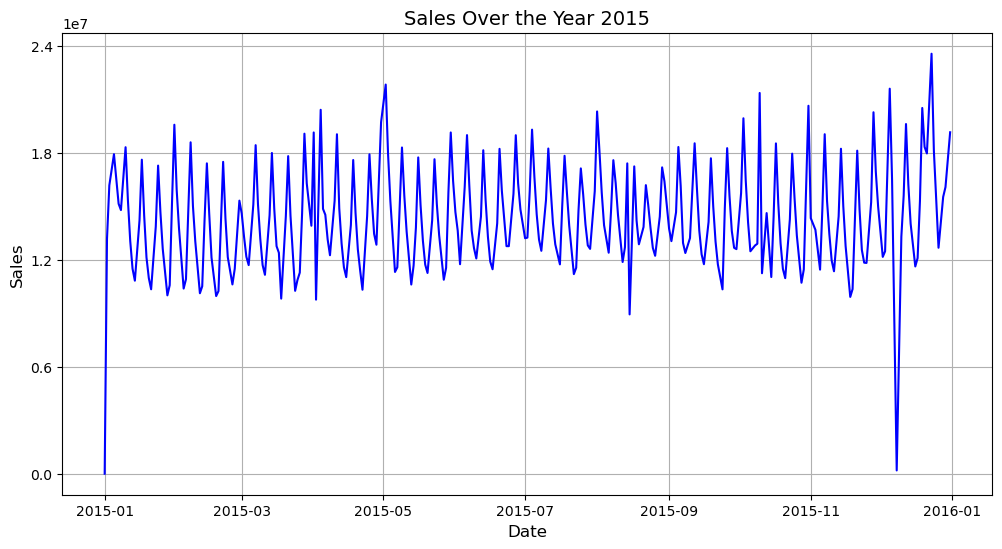

In [245]:
plot_sales_by_year(sales_train_formatted_df, 2015)

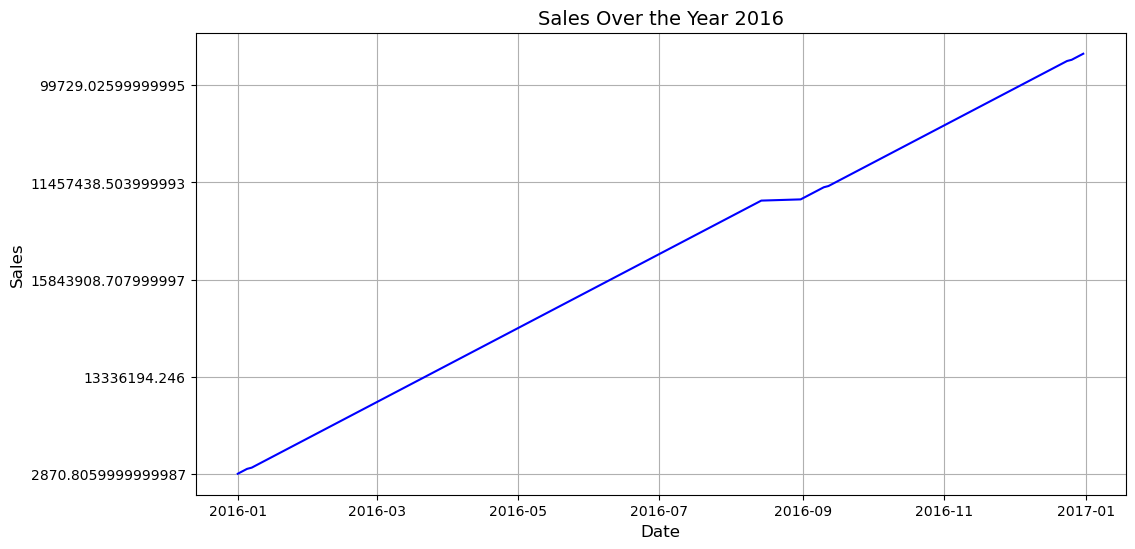

In [210]:
plot_sales_by_year(sales_train_df, 2016)

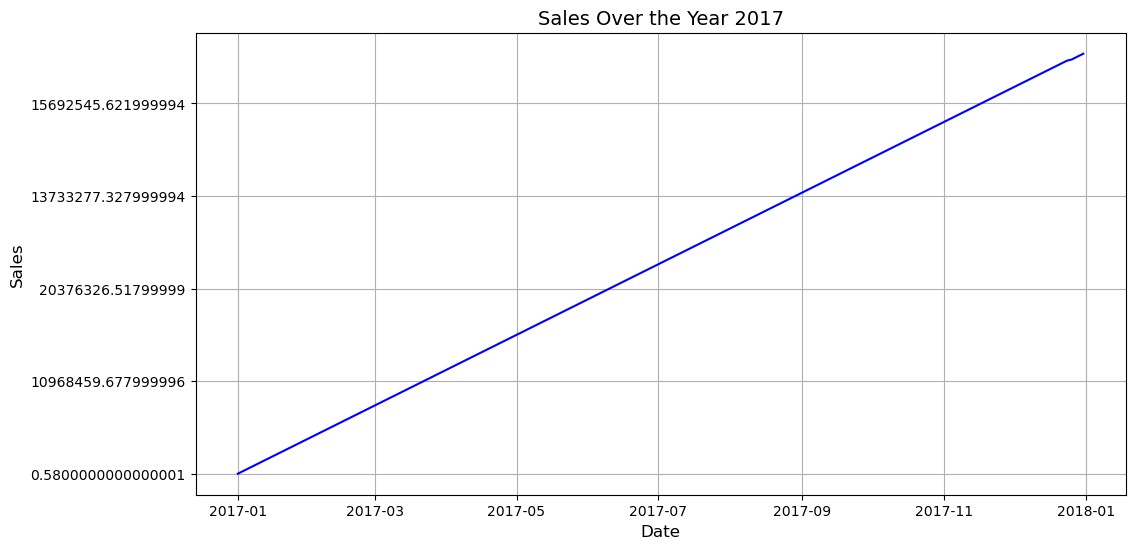

In [211]:
plot_sales_by_year(sales_train_df, 2017)

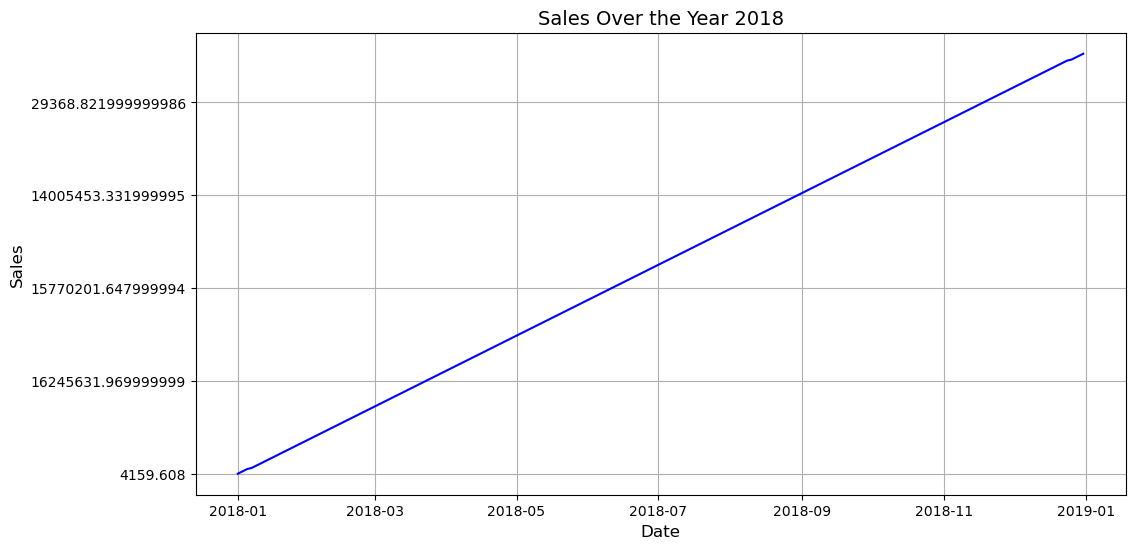

In [212]:
plot_sales_by_year(sales_train_df, 2018)

In [214]:
def plot_grouped_sales_by_month_with_avg(df):
    df['DATE'] = pd.to_datetime(df['DATE'])
    
    df['Year'] = df['DATE'].dt.year
    df['Month'] = df['DATE'].dt.month
    
    monthly_sales = df.groupby(['Year', 'Month'])['SALES'].sum().unstack('Year')
    
    monthly_avg_sales = monthly_sales.mean(axis=1)

    ax = monthly_sales.plot(kind='bar', figsize=(12, 6), width=0.8, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    
    plt.plot(monthly_avg_sales.index - 1, monthly_avg_sales.values, linestyle='--', marker='o', color='black', label='Average')
    
    plt.title('Total Sales Grouped by Month for Each Year with Average', fontsize=14)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Total Sales', fontsize=12)
    plt.xticks(rotation=0)
    plt.grid(True)
    plt.legend(title='Year', loc='upper left')
    plt.show()

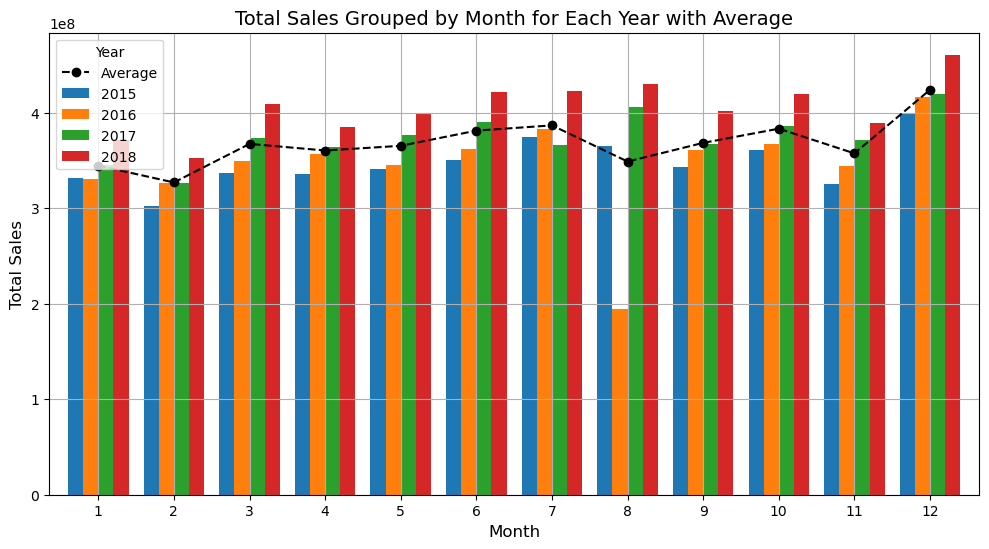

In [216]:
plot_grouped_sales_by_month_with_avg(sales_train_formatted_df)

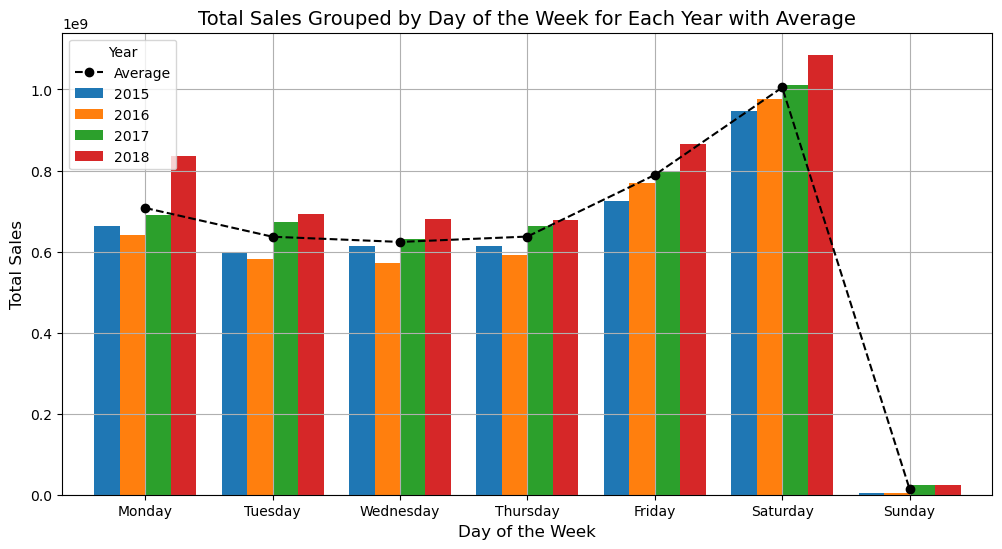

In [217]:
def plot_grouped_sales_by_day_of_week_with_avg(df):
    df['DATE'] = pd.to_datetime(df['DATE'])
    
    df['Year'] = df['DATE'].dt.year
    df['DayOfWeek'] = df['DATE'].dt.dayofweek  # 0 = Monday, 6 = Sunday
    
    weekly_sales = df.groupby(['Year', 'DayOfWeek'])['SALES'].sum().unstack('Year')
    
    weekly_avg_sales = weekly_sales.mean(axis=1)

    ax = weekly_sales.plot(kind='bar', figsize=(12, 6), width=0.8, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    
    plt.plot(weekly_avg_sales.index, weekly_avg_sales.values, linestyle='--', marker='o', color='black', label='Average')
    
    ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    
    plt.title('Total Sales Grouped by Day of the Week for Each Year with Average', fontsize=14)
    plt.xlabel('Day of the Week', fontsize=12)
    plt.ylabel('Total Sales', fontsize=12)
    plt.xticks(rotation=0)
    plt.grid(True)
    plt.legend(title='Year', loc='upper left')
    plt.show()

plot_grouped_sales_by_day_of_week_with_avg(sales_train_formatted_df)


##### Task 4: Outliers
* Identify possible outliers
* ¿Are there missing values?, ¿How would you deal with them?

In [ ]:
...

##### Taskk 5: Open/Close datase
* Plot a two-line graph. Each line should represent the amount of stores open/close at each day

In [ ]:
...

##### Task 6: Seasonality
* ¿Does sales follow a trend?
* ¿Can you identify a pattern on sales?
* ¿Are sales regular over all the year?

In [13]:
...

Ellipsis

##### Task 7: Optionaly
* If consider there are any kind of analysis that still can be done and would be useful for a forecasting task, that's the place to do it

In [ ]:
...

##### Task 8: Dataset creation
* At this stage, you should be capable of creating a dataset for a forecasting task. The goal is to populate the SALES column in the test submission file. To achieve this, you will need to first create a dataset and then train a model. You are encouraged to utilize all available information in the CSV files (and optionally, from the internet) to compile a single CSV file containing all chosen features along with the target variable.
* tip: Depending on the model you want to use, it's possible that categorical variables needs a special processing 😉.